In [106]:
import re
import numpy as np
import pandas as pd
from sklearn import datasets
from numpy import random
from sklearn.svm import SVC
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
import sklearn.ensemble as ske
from operator import itemgetter
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, accuracy_score
import math

%matplotlib inline

### 1. 写一个函数，将一个多类别变量转化为多个二元虚拟变量，不用 sklearn 库
#### (1) 为什么在聚类中使用虚拟变量？

- 如果不把分类变量转为虚拟变量，可能的一个方法，是把分类变量转为连续型的数字，如0，1，2，但这样会产生一些问题。
  举个例子，三个分类变量黄绿紫的编码示例：  

  类   | 连  |  虚     
  黄   |    0        | 1 0 0     
  绿     |    1        | 0 1 0     
  紫     |    2        | 0 0 1    

  如果用连续变量来表示黄绿紫三个变量，很明显，黄紫之间的距离为2，黄绿之间的距离为1。这样，用连续变量来编码分类变量，也就对权重平等的名义变量造成了不必要的距离差异。然而，设置虚拟变量则可避开这一问题。

#### (2) 在聚类中使用虚拟变量的好处？
 
- 虚拟变量使得聚类中对名义变量的欧氏距离计算变得可能，也就是说，我们可以把区间变量和名义变量结合到聚类结果中。     
  如果不用虚拟变量，会产生怎样的变化？可能会产生用k－means对待区间变量，用k－modes来处理名义特征。    
  在聚类中，遇到像性别和种族这样的名义变量，和像年龄收入这样的区间变量，这样的不同会干扰结果解析。

- 再说说两分编码法 (0, 1) 的缺点。比如，它会大大增加特征空间的维度，也就会人工地增加样本间的距离。要避免这一问题，可以考虑使用k-prototypes方法。

#### a. 把例子中的分类变量黄绿紫转化为二元虚拟变量，用到 pandas get_dummies() 函数

In [107]:
pd.Series(['yellow', 'purple', 'green']).str.get_dummies()

green  purple  yellow
0      0       0       1
1      0       1       0
2      1       0       0

#### b. 如变量不只有黄，绿，紫，而是有黄紫，绿紫，黄，绿，紫这样的分类，该怎么转化为二元虚拟变量？

In [108]:
s = pd.Series(['purple|yellow', 'purple|green', 'yellow', 'purple', 'green']).str.get_dummies()
s

green  purple  yellow
0      0       1       1
1      1       1       0
2      0       0       1
3      0       1       0
4      1       0       0

#### c. 自己写一个函数，实现虚拟变量转换
思路：
0. 创建变量 list
1. 依据变量 list 的特点，创建矩阵并写入 dataframe    
🌰 如变量为黄紫，黄绿，黄，紫，绿，行数为5（变量 list 中的所有元素），列数为3（独特的元素）
2. 将变量 list 填充到每一列数据中
3. 遍历每列，如果数据包涵了列名，返回1，未包含，返回0

In [109]:
ctgs = [['purple', 'yellow',], ['purple', 'green'], ['yellow'], ['purple'], ['green'] ]
def dummy_var(lsts):
    var = set()
    for lst in lsts:
        for subctg in lst:
            var.add(subctg)
    sj = pd.DataFrame(np.random.randn(len(lsts), len(var)), columns = var)
    for col in sj.columns:
        sj[col] = lsts
        sj[col] = sj[col].map(lambda x:1 if col in x else 0)
    sj['variable'] = lsts 
    return sj
dummy_var(ctgs)

purple  green  yellow          variable
0       1      0       1  [purple, yellow]
1       1      1       0   [purple, green]
2       0      0       1          [yellow]
3       1      0       0          [purple]
4       0      1       0           [green]

### 2. 写一个函数，实现交叉验证的功能，不使用sklearn库

#### (1) 使用交叉验证的原因    
让我们通过以下几幅图来理解这个问题：    
<img src="http://scikit-learn.org/stable/_images/plot_underfitting_overfitting_001.png" width="70%" height="100%" style="float:left"/>

#### 此处我们试图找到 x 和 y 的关系。三个模型各自做了如下工作：
- **第一个模型**：此模型使用了线性等式。对于训练用的数据点，这样的模型有很大误差。这是“拟合不足”(“Under fitting”）的一个例子，不足以发掘数据背后的趋势。
- **第二个模型**：该模型发现了 x 和 y 的正确关系，误差低/概括程度高。
- **第三个模型**：这个模型对于训练数据几乎是零误差。因为，此关系模型把每个数据点的偏差（包括噪声）都纳入了考虑范围，也就是说，这个模型太过敏感，甚至会捕捉到只在当前数据训练集出现的一些随机模式。这是“过度拟合”（“Over fitting”）的一个例子。
- **交叉验证**：在数据科学竞赛中，一个常见的做法是对多个模型进行迭代，从中选择表现更好的。然而，最终的分数是否会有改善依然未知，因为我们不知道这个模型是更好的发掘潜在关系了，还是过度拟合了。为了解答这个难题，我们应该使用交叉验证（cross validation）技术。它能帮我们得到更有概括性的关系模型。

#### (2) 什么是交叉验证？
- 交叉验证意味着需要保留一个样本数据集，不用来训练模型。在最终完成模型前，用这个数据集验证模型。
- 交叉验证步骤：   
  a.保留一个样本数据集   
  b.用剩余部分训练模型   
  c.用保留的数据集验证模型

#### (3) 交叉验证的常用方法是什么？

####  **Hold Out 法**
   - 保留一定比例的数据集用作验证，剩下的训练模型，再用验证集测试模型表现
   - 缺陷
       - 由于只使用了一定比例的数据训练模型，原数据中一些重要的信息可能被忽略     
       - 从严格意义上来说，Hold-Out 检验不算是交叉检验，因为该方法没有达到交叉检验的思想，而且最后验证准确性的高低和原始数组的分类有很大的关系，所以该方法得到的结果在某些场景中并不具备特别大的说服力

#### 一个简单的函数实现
上周 titanic 数据的一个练习中，实现过非 sklearn库的 hold out法交叉验证，这里总结为一个函数：   
先对数据进行排列，接着把数据为两个子集

In [110]:
def hold_out(X,y,size):
# 0 < size < 1
    order = np.random.permutation(len(x))
    X = X[order]
    y = y[order].astype(np.float)
    X_train = X[:int(size * len(x))]
    y_train = y[:int(size * len(x))]
    X_test = X[int(size * len(x)):]
    y_test = y[int(size * len(x)):]
    return X_train, X_test, y_train, y_test

### 3. 使用 sklearn 库中的其他分类方法，来预测 titanic 的生存情况
上周已用过 支持向量机 SVM 和 随机森林两种方法，代码如下

In [111]:
# 数据导入和清理
train = pd.read_csv("train.csv") 
train = train.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1)
train['Age'] = train['Age'].fillna(train['Age'].median())
train= train.dropna(how = 'any')

# 设立公式，建立数据框
formula =  'Survived ~ C(Pclass) + C(Sex) + Age + SibSp' 
y, x = dmatrices(formula, data=train, return_type='matrix')

# 将公式数据框中的数据放入 numpy array
# 挑选感兴趣的变量来分析:通过刚才的回归分析，已知性别和船舱对是否生还的影响较大，这里选择代表性别 3 和船舱 2 的两列来分析
X = np.asarray(x)
# y 值是这样的数据，array([[ 0.], [ 1.], [ 1.], [ 1.] ...]), 用 np.ravel() 转换为 array([ 0.,  1.,  1.,  1.,  0.,  0., ...])
y = np.asarray(y).ravel()
X = X[:,[2, 3]]  

# 随机排列 x, y值 
np.random.seed(123)
order = np.random.permutation(len(x))
X = X[order]
y = y[order].astype(np.float)

# 做一个交叉验证，前80%的数据用来训练，后20%的数据用来检验
X_train = X[:int(.8 * len(x))]
y_train = y[:int(.8 * len(x))]
X_test = X[int(.8 * len(x)):]
y_test = y[int(.8 * len(x)):]

# 1. 支持向量机
# gamma 参数: 参数 gamma 表示超平面的线性平滑度，当使用线性核函数构建 SVM 时，模型中不存在 gamma 参数。
# 我们知道: gamma 越小，超平面越接近于直线，但是如果 gamma 选取过大，超平面将会变得非常弯曲，这会导致过度拟合问题。
poly = SVC(kernel='poly', gamma=2.5)
poly.fit(X_train, y_train)
print u'1. 支持向量机算法预测评分 :',poly.score(X_test, y_test) 

1. 支持向量机算法预测评分 : 0.775280898876


In [112]:
# 创建随机森林模型
Forest_formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp' 
y, x = dmatrices(Forest_formula, data=train, return_type='dataframe')
# y 转 1 维
y = np.asarray(y).ravel()
# 把数据拟合进拟合模型
results = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

# 显示结果，精确度很理想，为0.9
print u'2. 随机森林预测评分 :',results.score(x, y)

2. 随机森林预测评分 : 0.902137232846


### 4. 研究 kaggle 中的 Digit Recognizer 数据，尝试用一些特征工程来提取数字的特征，并放入分类器中观察预测准确率，相对直接使用原始变量是否有提升
#### (1) 数据导入与初探
digit recognition 的数据从 sklearn 数据集中导入

1. 样本大小和特征数量: (1797, 64), 图片个数: (1797,)
   包含的数字: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2. 随机查看三张图片:


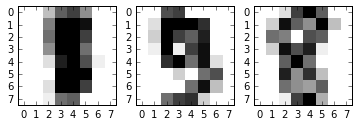

In [113]:
# 导入数据集
digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

# 查看有多少张图片
print(u"1. 样本大小和特征数量: %r, 图片个数: %r" % (X.shape, y.shape))
print(u"   包含的数字: %r" % list(np.unique(y)))

# 随机查看三张图片
print u'2. 随机查看三张图片:'
fig, (pic1, pic2, pic3) = plt.subplots(1, 3)
pic1.imshow(digits.images[random.randint(n_samples)], cmap=plt.cm.gray_r, interpolation='nearest')
pic2.imshow(digits.images[random.randint(n_samples)], cmap=plt.cm.gray_r, interpolation='nearest')
pic3.imshow(digits.images[random.randint(n_samples)], cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

#### (2) randomizedPCA 提取特征
原来有 64 个特征值，对特征值进行降维，提取主要特征1

In [114]:
pca = PCA(n_components=20)
pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape

(1797, 20)

#### (3) 交叉验证
前80%的数据做训练用，后20％的数据做验证用

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=12345)
Xpca_train, Xpca_test = train_test_split(X_pca,train_size=0.8,random_state=12345)

#### (4) 分类及特征工程前后对比
SVM 支持向量机

In [116]:
svc = SVC(kernel='rbf', C=100, gamma=0.001)
svc_fit = svc.fit(X_train, y_train)
SVM_score = svc_fit.score(X_test, y_test) 

svc1 = SVC(kernel='rbf', C=100, gamma=0.001).fit(Xpca_train, y_train)
svc1_fit = svc1.fit(Xpca_train, y_train)
SVM_score_pca = svc1_fit.score(Xpca_test, y_test) 

print u'特征提取之间的预测评分 %r, 特征提取之后的预测评分 %r, 预测准确率有所提升' %(SVM_score, SVM_score_pca)

特征提取之间的预测评分 0.9916666666666667, 特征提取之后的预测评分 0.99444444444444446, 预测准确率有所提升


#### (5) 查看预测结果

从验证数据集里抽取一张图片：

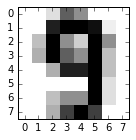

 预测结果:  [9]


/Users/Q16/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [117]:
print u'从验证数据集里抽取一张图片：',
plt.figure(1, figsize=(2, 2))
plt.imshow(digits.images[-2], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

print u'预测结果: ', svc.predict(digits.data[-2])

### 5. 用 numpy 库实现 K-nearest neighbors 分类
#### (1) 什么是 KNN 算法？
- K Nearest Neighbor算法又叫KNN算法，是机器学习里面一个比较经典且容易理解的算法。其中的 K 表示最接近自己的 K 个数据样本。
- KNN 算法和 K-Means 算法不同的是，K-Means 算法用来聚类，用来判断哪些东西是一个比较相近的类型，而 KNN 算法是用来做归类的，也就是说，有一个样本空间里的样本分成很几个类型，然后，给定一个待分类的数据，通过计算接近自己最近的 K 个样本来判断这个待分类数据属于哪个分类。
- 可以简单将 KNN 算法理解为，数据点 A 属于哪一类，由离它最近的K个点来投票，投票结果决定 A 该被归为哪一类

#### 一个例子
<img src="http://coolshell.cn//wp-content/uploads/2012/08/220px-KnnClassification.svg_.png" width="27%" height="100%" style="float:left"/>

#### 图中的有两类数据，正方形和三角形；圆形为待分类的数据。
- K=3，离圆形点最近的有2个三角形和1个正方形，则由这3个点投票，于是圆形的待分类点属于三角形
- K=5，那么离圆形点最近的有2个三角形和3个正方形，由5个点投票，于是圆形的待分类点属于正方形。

#### (2) 选取了 iris 数据来进行 KNN 分类

In [118]:
# 导入数据，经典花分类数据集
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.6, random_state=1)
 
# 交叉验证
train = np.array(zip(X_train,y_train))
test = np.array(zip(X_test, y_test))
 
# 1) 已知两个数据点，计算欧氏距离
def get_distance(point1, point2):
    points = zip(point1, point2)
    diffs_squared_distance = [pow(a - b, 2) for (a, b) in points]
    return math.sqrt(sum(diffs_squared_distance))

def get_neighbours(training_set, test_instance, k):
    distances = [_get_tuple_distance(training_instance, test_instance) for training_instance in training_set]
 
    # 1 为训练值与检验值之间的距离 
    sorted_distances = sorted(distances, key=itemgetter(1))
 
    # 只抽取训练值
    sorted_training_instances = [tuple[0] for tuple in sorted_distances]
 
    # 选择 k 个元素
    return sorted_training_instances[:k]
 
def _get_tuple_distance(training_instance, test_instance):
    return (training_instance, get_distance(test_instance, training_instance[0]))
 
def get_majority_vote(neighbours):
    # index 1 is the class
    classes = [neighbour[1] for neighbour in neighbours]
    count = Counter(classes)
    return count.most_common()[0][0]

def main():
 
    predictions = []
 
    # 先随意将k设置为5，即初始尝试的分类值为5
    k = 5
 
    for x in range(len(X_test)):
 
            print 'Classifying test instance number ' + str(x) + ":",
            neighbours = get_neighbours(training_set=train, test_instance=test[x][0], k=5)
            majority_vote = get_majority_vote(neighbours)
            predictions.append(majority_vote)
            print 'Predicted label=' + str(majority_vote) + ', Actual label=' + str(test[x][1])
 
    # 总结
    print '\nThe overall accuracy of the model is: ' + str(accuracy_score(y_test, predictions)) + "\n"
    report = classification_report(y_test, predictions, target_names = iris.target_names)
    print 'A detailed classification report: \n\n' + report
 
if __name__ == "__main__":
    main()

Classifying test instance number 0: Predicted label=0, Actual label=0
Classifying test instance number 1: Predicted label=1, Actual label=1
Classifying test instance number 2: Predicted label=1, Actual label=1
Classifying test instance number 3: Predicted label=0, Actual label=0
Classifying test instance number 4: Predicted label=2, Actual label=2
Classifying test instance number 5: Predicted label=1, Actual label=1
Classifying test instance number 6: Predicted label=2, Actual label=2
Classifying test instance number 7: Predicted label=0, Actual label=0
Classifying test instance number 8: Predicted label=0, Actual label=0
Classifying test instance number 9: Predicted label=2, Actual label=2
Classifying test instance number 10: Predicted label=1, Actual label=1
Classifying test instance number 11: Predicted label=0, Actual label=0
Classifying test instance number 12: Predicted label=2, Actual label=2
Classifying test instance number 13: Predicted label=1, Actual label=1
Classifying test

### 笔记

#### (1) 交叉验证其他方法

#### **留一 ( LOOCV )**

   - 步骤1: 只保留一个数据点用作验证，用剩余的数据集训练模型；步骤2: 对每个数据点重复步骤1。
   - 优点：使用了所有数据点，因此误差较小
   - 缺点：- 验证过程重复了 n 次（ n 为数据点个数），导致执行时间很长；由于只使用了一个数据点验证，该方法导致模型有效性的差异更大。得到的估计结果深受此点的影响。如果这是个离群点，会引起较大偏差。
   
####   **K 层交叉验证法 (K- fold cross validation)**

- 总结前两种验证方法：
    - a.训练模型时，应该使用一定比例的数据集来训练模型，否则可能会创建出偏误较大的模型
    - b.验证用的数据点，其比例应该恰到好处。如果太少，会导致验证模型有效性时，得到的结果波动较大。
    - c.训练和验证过程应该重复多次。训练集和验证集不能一成不变。这样有助于验证模型有效性。
 
 
- K 层交叉验证 -- 兼顾上述三个方面的交叉验证法
     - 定义：把整个数据集随机分成 K“层”，用其中 K-1 层训练模型，然后用第K层验证；记录从每个预测结果获得的误差；重复这个过程，直到每“层”数据都作过验证集；记录下的 k 个误差的平均值，被称为交叉验证误差（cross-validation error）。可以被用做衡量模型表现的标准。


- “如何确定合适的k值？”    
     - K 值越小，偏误越大；K 值太大，所得结果会变化多端
     - K 值小，会变得像“验证集法”；K 值大，则会变得像“留一法”（LOOCV）。通常建议的分层值是 k=10 
   
   
- 如何衡量模型的偏误/变化程度？     
     - K 层交叉检验之后，我们得到 K 个不同的模型误差估算值（e1, e2 …..ek）。理想的情况是，这些误差值相加得 0 。要计算模型的偏误，我们把所有这些误差值相加。平均值越低，模型越优秀。
     - 模型表现变化程度的计算与之类似。取所有误差值的标准差，标准差越小说明模型随训练数据的变化越小。
     - 我们应该试图在偏误和变化程度间找到一种平衡。降低变化程度、控制偏误可以达到这个目的。这样会得到更好的预测模型。进行这个取舍，通常会得出复杂程度较低的预测模型。